<a href="https://colab.research.google.com/github/cemreefe/cmpe493-project/blob/main/493_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install xmltodict

import os
import tarfile
import pandas as pd
import xmltodict
import json
import io   
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_file(path):
  with open(path, 'r') as f:
    return f.read()

In [4]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  os.makedirs('drive/MyDrive/CMPE/CMPE493')

In [5]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'):
  !curl https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml --output drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt'):
  !curl https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt --output drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz'):
  !curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz --output drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz

In [6]:
if not os.path.exists('2020-07-16'):
  tar = tarfile.open('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz', "r:gz")
  tar.extractall()
  tar.close()

In [7]:
df_metadata = pd.read_csv('2020-07-16/metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
del df_metadata['sha'], df_metadata['source_x'], df_metadata['doi'], df_metadata['pmcid'], df_metadata['pubmed_id'], df_metadata['license'], df_metadata['publish_time'], df_metadata['authors'], df_metadata['journal'], df_metadata['mag_id'], df_metadata['who_covidence_id'], df_metadata['arxiv_id'], df_metadata['pdf_json_files'], df_metadata['pmc_json_files'], df_metadata['url'], df_metadata['s2_id']

In [9]:
df_metadata[df_metadata['cord_uid'] == 'ug7v899j']

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...


In [10]:
df_metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)

In [11]:
df_metadata

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...
...,...,...,...
192504,z4ro6lmh,Rapid radiological improvement of COVID-19 pne...,NaN
192505,hi8k8wvb,SARS E protein in phospholipid bilayers: an an...,Abstract We report on an anomalous X-ray refle...
192506,ma3ndg41,Italian Society of Interventional Cardiology (...,COVID‐19 pandemic raised the issue to guarante...
192507,wh10285j,"Nimble, Together: A Training Program's Respons...",NaN


In [12]:
topic_relevances = 'topic iter document_id judgement\n' + read_file('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt')

df_relevances = pd.read_csv(  io.StringIO(topic_relevances)  , sep=" ")
del df_relevances['iter']

df_relevances

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [13]:
topics_obj = xmltodict.parse(read_file('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'))
topics     = json.loads(json.dumps(topics_obj))

topics_dict = {}
for topic in topics['topics']['topic']:
  # a topic has the following fields:
  #  * @number
  #  * narrative
  #  * query
  #  * question
  topics_dict[topic['@number']] = topic['query'] + ' ' + topic['question'] + ' ' + topic['narrative']

In [14]:
len(topics_dict)

50

# Data so far

* `topics_dict` 
      has `topic-id` for keys, and topic description for values
* `df_relevances` 
      has the following three columns:
      topic	document-id	judgement
* `df_metadata`
      holds information about the documents
      has the following three columns (others are deleted):
      cord_uid	title	abstract


In [17]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
def strip_non_alphanum(text):
    import re
    return ' '.join(re.compile(r'\W+', re.UNICODE).split(text))

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
ex_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = ex_vectorizer.fit_transform(corpus)
print(ex_vectorizer.get_feature_names())

print(X.shape)

['document', 'first', 'one', 'second', 'third']
(4, 5)


In [20]:
ex_feature_names = ex_vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=X[3] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=ex_feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
first,0.777221
document,0.629228
one,0.000000
second,0.000000
third,0.000000


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(X[1], X).flatten()


array([0.49534236, 1.        , 0.        , 0.49534236])

In [22]:
import numpy as np

docs = np.array(df_metadata)
contents = {}

for doc in docs:
  contents[doc[0]] = f'{doc[1]} {doc[2]}'

In [23]:
import string
import re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
sw = stopwords.words('english')

def preprocess(s):
  s = s.casefold()
  s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  s = re.sub("\d+", "", s) #Delete numbers
  s = ' '.join([porter_stemmer.stem(word) for word in s.split() if word not in sw or word != 'nan'])
  return s

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(preprocessor=preprocess)
vectors = vectorizer.fit_transform(list(contents.values()) + list(topics_dict.values()))

In [25]:
doc_vectors = vectors[:-50]
topic_vectors = vectors[-50:]

In [26]:
topic_vectors.shape

(50, 145403)

In [27]:
doc_vectors_dict = {
    docs[i][0] : doc_vectors[i]
    for i in range(0,len(docs))
}

In [28]:
topic_vectors_dict = {
    key : topic_vectors[i]
    for i, key in enumerate(topics_dict.keys())
}

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
#Takes random doc_id and prints most relevant topic
ex_document = df_metadata.sample().cord_uid.to_string().split()[1]
similarity = cosine_similarity(doc_vectors_dict[ex_document],topic_vectors).flatten()

print(ex_document)
print(similarity)
print(np.max(similarity))
print(np.argmax(similarity))
print(contents[ex_document])
print(topics_dict[str(np.argmax(similarity) + 1)])

d3jeatqa
[0.05602038 0.02164536 0.03235314 0.01266504 0.03023446 0.00542584
 0.02501499 0.0263981  0.0143989  0.00796664 0.01890146 0.02808453
 0.02044312 0.02498797 0.01928159 0.02877916 0.01339059 0.0174923
 0.03158582 0.01531113 0.04837826 0.02297926 0.03041101 0.03125868
 0.02141139 0.03123583 0.03096108 0.01936463 0.03955718 0.00397944
 0.03892465 0.01182656 0.01605308 0.01816546 0.01124346 0.03132217
 0.03248134 0.03386444 0.02755386 0.0626929  0.03708485 0.02152721
 0.01005348 0.01905733 0.01776011 0.01311981 0.01664201 0.04219175
 0.01572938 0.01004072]
0.06269289596212677
39
Plant diversity patterns in neotropical dry forests and their conservation implications. Seasonally dry tropical forests are distributed across Latin America and the Caribbean and are highly threatened, with less than 10% of their original extent remaining in many countries. Using 835 inventories covering 4660 species of woody plants, we show marked floristic turnover among inventories and regions, which m

In [30]:
df_relevances['cosine_similarity'] = df_relevances.apply(
    lambda r: cosine_similarity(topic_vectors_dict[str(r.topic)], doc_vectors_dict[r.document_id]).flatten()[0],
    axis=1
)

In [31]:
df_relevances

,topic,document_id,judgement,cosine_similarity
0,1,005b2j4b,2,0.114604
1,1,00fmeepz,1,0.246053
2,1,010vptx3,2,0.155122
3,1,0194oljo,1,0.237402
4,1,021q9884,1,0.138621
...,...,...,...,...
69313,50,zvop8bxh,2,0.046728
69314,50,zwf26o63,1,0.246338
69315,50,zwsvlnwe,0,0.257470
69316,50,zxr01yln,1,0.078930


In [32]:
stuff = np.abs(np.array(df_relevances.judgement) - np.array(df_relevances.cosine_similarity)*2)

In [33]:
np.mean(stuff)

0.5928020465990212

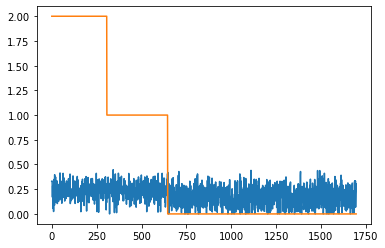

In [34]:
similarities = np.array(df_relevances[df_relevances['topic'] == 5].sort_values(by=["judgement"],ascending=False).cosine_similarity)

import matplotlib.pyplot as plt
plt.plot(similarities)
plt.plot(np.array(df_relevances[df_relevances['topic'] == 5].sort_values(by=["judgement"],ascending=False).judgement))

In [36]:
import pickle
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))
pickle.dump(vectors, open("vectors.pickle", "wb"))

In [47]:
df_results = df_relevances.copy()
df_results.insert(1, 'iter', 0)
df_results.insert(3, 'rank', 0)
del df_results['judgement']
df_results.insert(5, 'run_id', 0)

In [50]:
df_results

,topic,iter,document_id,rank,cosine_similarity,run_id
0,1,0,005b2j4b,0,0.114604,0
1,1,0,00fmeepz,0,0.246053,0
2,1,0,010vptx3,0,0.155122,0
3,1,0,0194oljo,0,0.237402,0
4,1,0,021q9884,0,0.138621,0
...,...,...,...,...,...,...
69313,50,0,zvop8bxh,0,0.046728,0
69314,50,0,zwf26o63,0,0.246338,0
69315,50,0,zwsvlnwe,0,0.257470,0
69316,50,0,zxr01yln,0,0.078930,0


In [54]:
df_results.to_csv('results.csv', sep=' ', index=False, header=False)